# Predictions
## - starting at the end

This notebook goes through the object recognition method Single Shot Multibox Detection (SSD) leveraging the implementation from https://github.com/cory8249/ssd_keras. This implementation is based on the second version on arXiv of the paper describing SSD https://arxiv.org/pdf/1512.02325v2.pdf. We will use the data made available at https://github.com/udacity/self-driving-car/tree/master/annotations as Data Set 1 from Udacity under the MIT license (https://github.com/udacity/self-driving-car/blob/master/LICENSE.md).

Let's get started by loading the necessary modules.

In [2]:
#import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import h5py
import pickle
import os 

from skimage.transform import resize

from ssd import SSD300
from ssd_utils import BBoxUtility


%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


And now let's list and save the classes that the trained model knows about. For ease later, we will also store the number of classes in a variable, including the background-class.

In [3]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

We're ready to build the model.

In [4]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)


Let's have a quick look at the architecture of the model that was constructed. We will go into more details later.


In [5]:
keras.utils.layer_utils.print_summary(model)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 300, 300, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

We'll now load the pre-trained weights

In [6]:
model.load_weights('weights_SSD300.hdf5', by_name=True)

and instantiate an object to help us operate on bounding boxes.

In [7]:
bbox_util = BBoxUtility(NUM_CLASSES)

Now we'll have a look at the methods and variables exposed by this class.

In [8]:
print("Bounding boxes:"), print(bbox_util.boxes), print("\n")
bbox_util.nms
print("Non-Maximum Suppression threshold:"), print(bbox_util.nms_thresh), print("\n")
print("Number of classes:"), print(bbox_util.num_classes), print("\n")
print("Number of priors:"), print(bbox_util.priors), print("\n")
print("Number of overlap threshold:"), print(bbox_util.overlap_threshold), print("\n")
bbox_util.scores
print("Maximum number of boxes to keep:"), print(bbox_util.top_k), print("\n")

Bounding boxes:
Tensor("Placeholder_67:0", shape=(?, 4), dtype=float32)


Non-Maximum Suppression threshold:
0.45


Number of classes:
21


Number of priors:
None


Number of overlap threshold:
0.5


Maximum number of boxes to keep:
400




(None, None, None)

In addition, the BBoxUtility class exposes the methods assign_boxes, decode_boxes, detection_out, encode_box, and iou.

To allow us to use 300 * 300 architecture we resized the images from udacity to this size. We now save the path to these images in a variable, load the file containing ground truth for test data, and sort the keys. We sort the keys to be in control of which images we inspect.

In [9]:
imgspath = os.path.expanduser('~/Documents/publicData/udacity_selfdrivingcar/object-detection-crowdai_resized300_300') #'/data/objRec/object-detection-crowdai_resized300_300/'
gt = pickle.load(open('crowdai_udacity_test.p', 'rb')) 
keys = sorted(gt.keys())

The ground truths are saved as a dictionary. Each key in the dictionary is the file name of an image in the test data. Each value is a numpy array with number of rows equal to the number of objects in the image. The first four columns of the array give the xmin, ymin, xmax, ymax coordinates of the bounding box. The remaining columns are a one-hot encoding of the class of the object contained in the bounding box. This ground truth file is the one we will see how to generate for the udacity data later, so there are only three columns after the first four, for each of the three classes "car", "pedestrian", and "truck". 

In [10]:
gt

{'1479503007781844650.jpg': array([[ 0.2625    ,  0.42416667,  0.553125  ,  0.82416667,  1.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.43083333,  0.253125  ,  0.8075    ,  1.        ,
          0.        ,  0.        ],
        [ 0.58489583,  0.47166667,  0.67447917,  0.53166667,  1.        ,
          0.        ,  0.        ],
        [ 0.909375  ,  0.445     ,  0.96822917,  0.4925    ,  1.        ,
          0.        ,  0.        ],
        [ 0.56354167,  0.44833333,  0.66458333,  0.50083333,  1.        ,
          0.        ,  0.        ],
        [ 0.22604167,  0.475     ,  0.30677083,  0.5575    ,  1.        ,
          0.        ,  0.        ],
        [ 0.6796875 ,  0.44      ,  0.70833333,  0.54      ,  0.        ,
          1.        ,  0.        ],
        [ 0.2203125 ,  0.465     ,  0.246875  ,  0.53166667,  0.        ,
          1.        ,  0.        ],
        [ 0.190625  ,  0.46      ,  0.22447917,  0.53      ,  0.        ,
          1.       

Now, let's inspect the predictions for an image. First we need to load it. After initialising the inputs and images lists, the code in the following cell can be repated for multiple images to inspect more than a single image.

In [11]:
inputs = []
images = []
gts = []
gtimgs = []
nimgs_to_inspect = 10
for ikey in range(0,nimgs_to_inspect):
    img_path = os.path.join(imgspath, keys[ikey])
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    gts.append(gt.get(keys[ikey]))
    gtimgs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

Run the image(s) through the network to get predictions. This will give a numpy array of size nimages * n_prior_boxes * (n_classes+12). With the SSD architecture for 300 * 300 images, there are 7308 prior boxes. We used the net pre-trained on VOC which has 20 classes, in addition to the background class. The 33 columns contain corrections to the prior boxes to make the predicted box fit the object better (first four columns), class_confidences (the confidence for the background is the first of these), and definitions of the prior boxes (8 numbers).

In [12]:
preds = model.predict(inputs, batch_size=1, verbose=1)

10/10 [==============================] - 11s    


In [13]:
print("Shape of predictions from the model:"), print(preds.shape), print("")
print("Classes:"), print(voc_classes), print("")
print("First few rows of the predictions array for the first image:")
preds[0,0:5,...]

Shape of predictions from the model:
(10, 7308, 33)

Classes:
['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable', 'Dog', 'Horse', 'Motorbike', 'Person', 'Pottedplant', 'Sheep', 'Sofa', 'Train', 'Tvmonitor']

First few rows of the predictions array for the first image:


array([[-0.76481736, -0.81279546, -0.65628737, -0.71545625,  0.98863846,
         0.00068306,  0.00030604,  0.00062651,  0.00180342,  0.0003841 ,
         0.00033542,  0.00088093,  0.00010203,  0.00051826,  0.00061466,
         0.00027302,  0.00026998,  0.00034357,  0.00013849,  0.00185156,
         0.00082446,  0.00081631,  0.00018062,  0.00013063,  0.00027838,
         0.        ,  0.        ,  0.06315789,  0.06315789,  0.1       ,
         0.1       ,  0.2       ,  0.2       ],
       [-0.34658453, -0.57116604, -0.8060087 , -0.48629624,  0.99032903,
         0.00038904,  0.00030777,  0.00125634,  0.00172142,  0.00027296,
         0.00033101,  0.00117314,  0.00018236,  0.00035648,  0.00034973,
         0.00013104,  0.00014634,  0.0001875 ,  0.00014064,  0.00122133,
         0.00029356,  0.00084069,  0.00010441,  0.0000913 ,  0.00017376,
         0.        ,  0.        ,  0.08386857,  0.04851323,  0.1       ,
         0.1       ,  0.2       ,  0.2       ],
       [-0.47354841, -0.6798

In [14]:
results = bbox_util.detection_out(preds) # keeps only rows with a non-background class of confidence at least 0.01, 
# and at most 200 such rows.
np.min(results[0][:,5])

0.40643298625946045

Run the two operations again, timing them. This is redundant and solely to quantify the inference time.

In [15]:
%%time
a = model.predict(inputs, batch_size=1) 
b = bbox_util.detection_out(a)

CPU times: user 1min 7s, sys: 3.76 s, total: 1min 10s
Wall time: 12 s


Visualise the predictions.

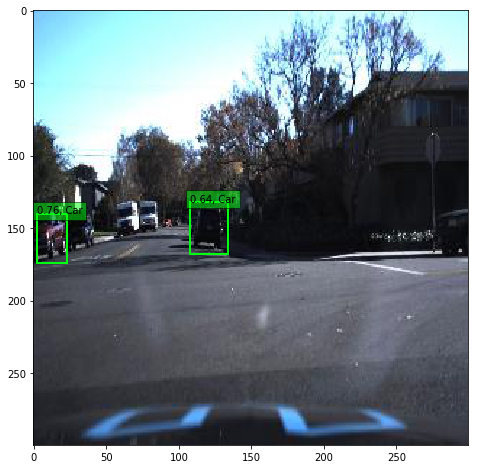

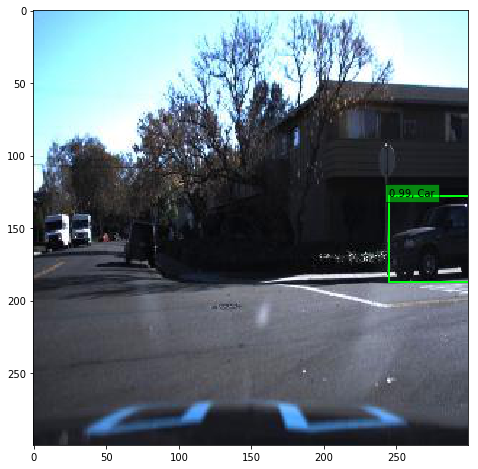

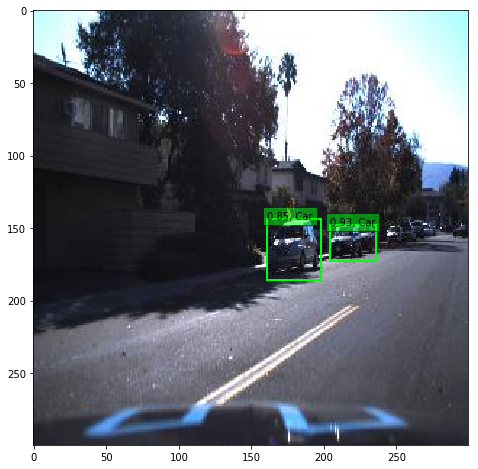

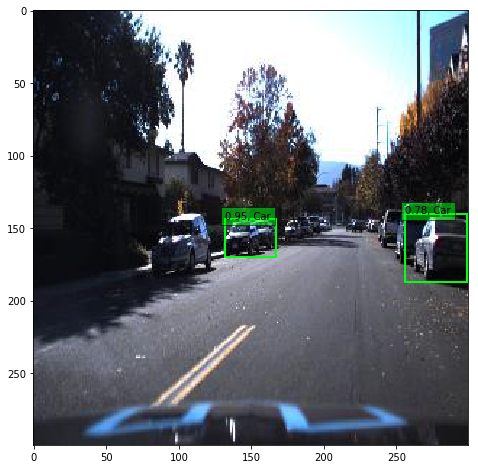

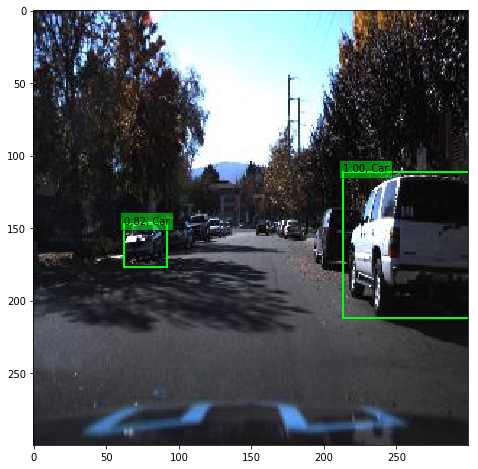

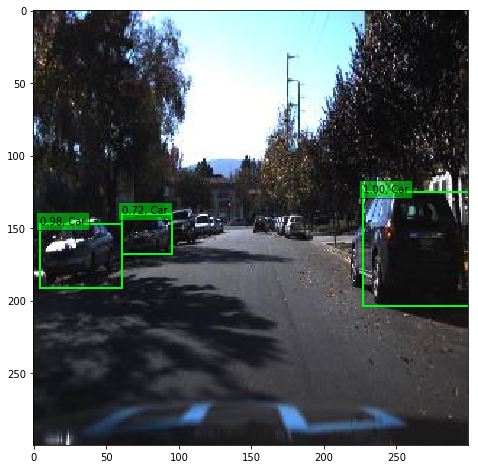

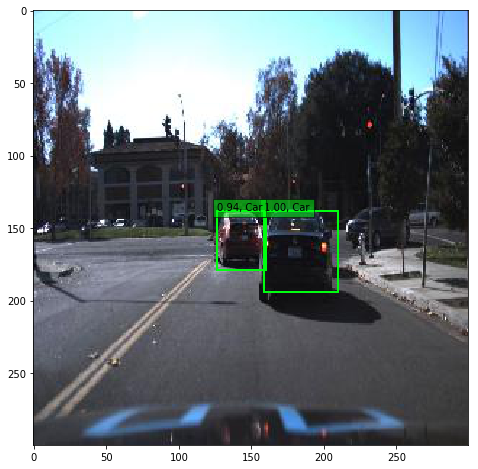

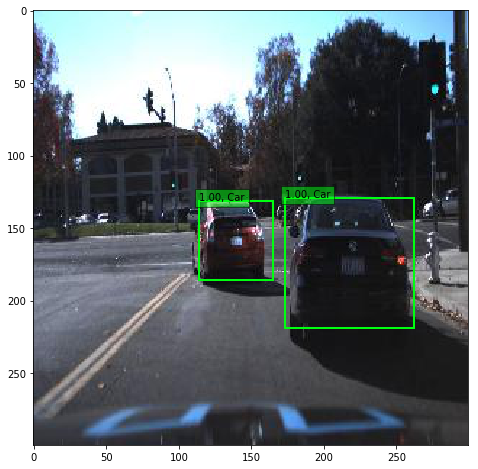

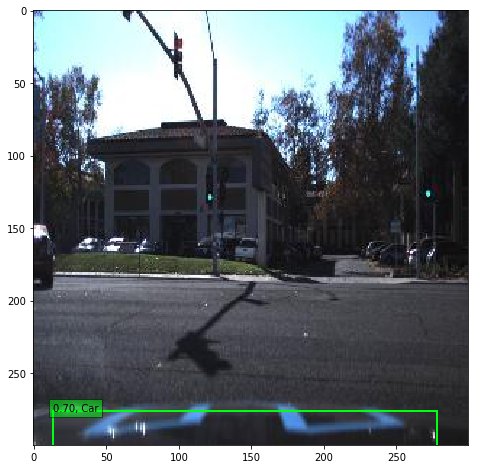

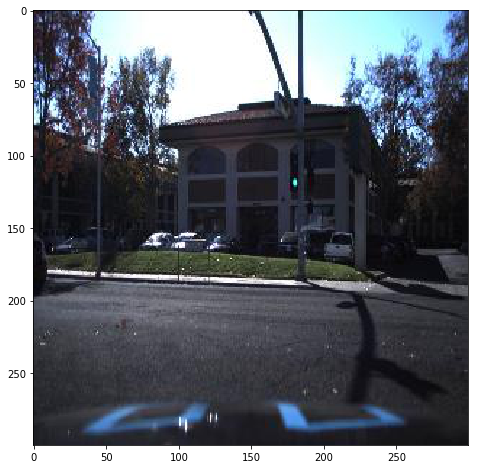

In [16]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

Now we've seen the predictions, let's see how they compare with the ground truth annotations for this image (keeping in mind that the ground truth annotations are based on the udacity data set while the predictions are from a model trained on the VOC data). Recall that the ground truths are encoded with one row for each object in an image. The first four columns give the xmin, ymin, xmax, and ymax coordinates while the remaining columns are a one-hot-encoding of the class of the object contained in the bounding box.

In [17]:
print(len(gts))
gts

10


[array([[ 0.36979167,  0.45      ,  0.43541667,  0.55416667,  1.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.45833333,  0.07760417,  0.57416667,  1.        ,
          0.        ,  0.        ],
        [ 0.07239583,  0.45666667,  0.140625  ,  0.55083333,  1.        ,
          0.        ,  0.        ],
        [ 0.19166667,  0.44      ,  0.24375   ,  0.52      ,  0.        ,
          0.        ,  1.        ],
        [ 0.24583333,  0.44      ,  0.28645833,  0.50916667,  0.        ,
          0.        ,  1.        ],
        [ 0.29270833,  0.47416667,  0.31979167,  0.5075    ,  1.        ,
          0.        ,  0.        ],
        [ 0.92135417,  0.44166667,  0.99895833,  0.56916667,  1.        ,
          0.        ,  0.        ],
        [ 0.35625   ,  0.475     ,  0.3765625 ,  0.52333333,  1.        ,
          0.        ,  0.        ],
        [ 0.31927083,  0.4675    ,  0.3390625 ,  0.49916667,  1.        ,
          0.        ,  0.        ]]),
 array([

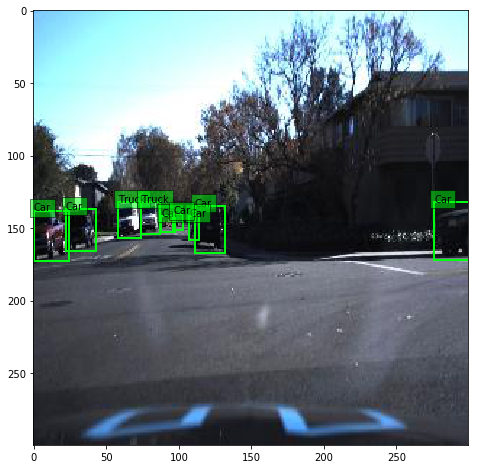

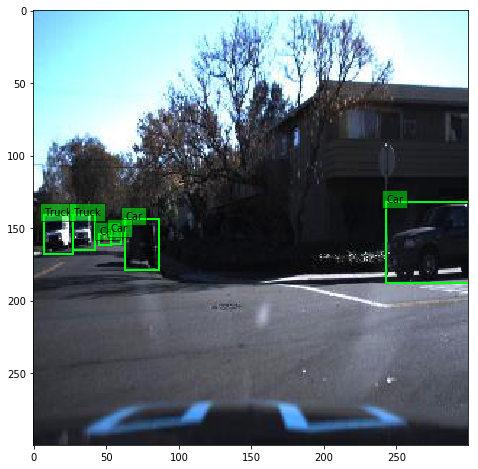

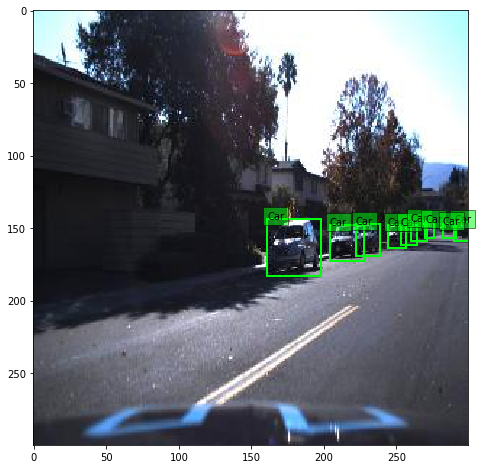

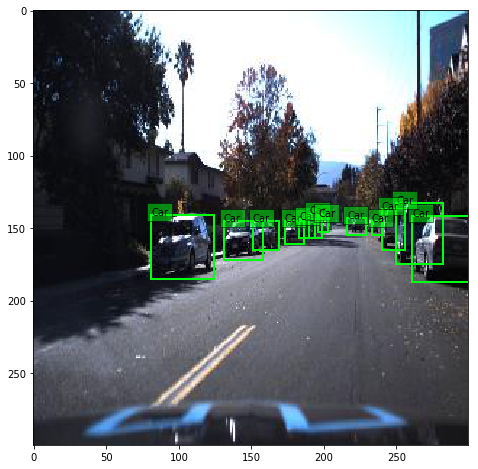

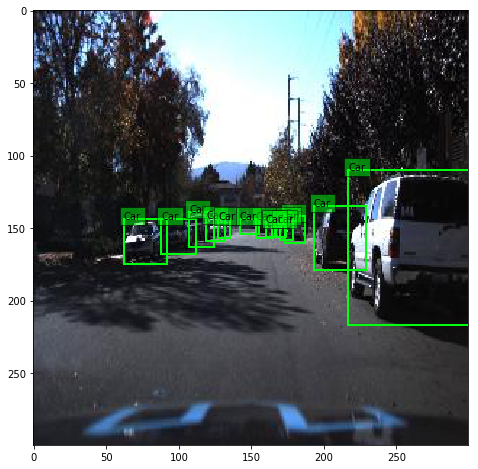

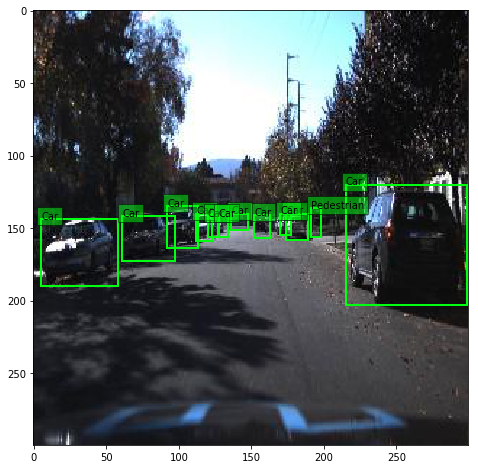

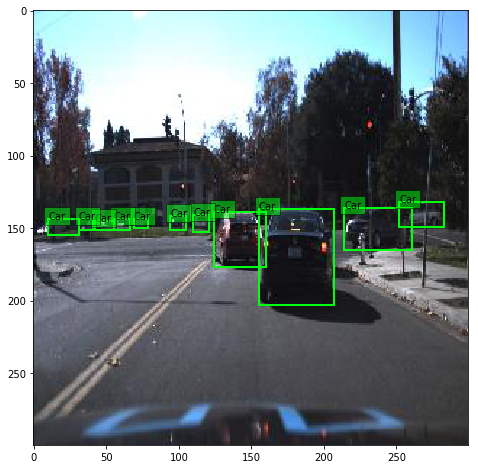

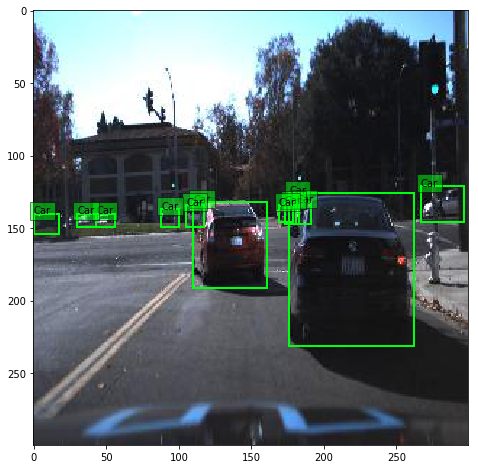

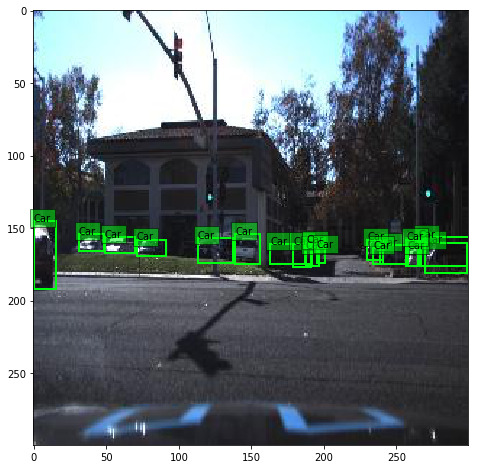

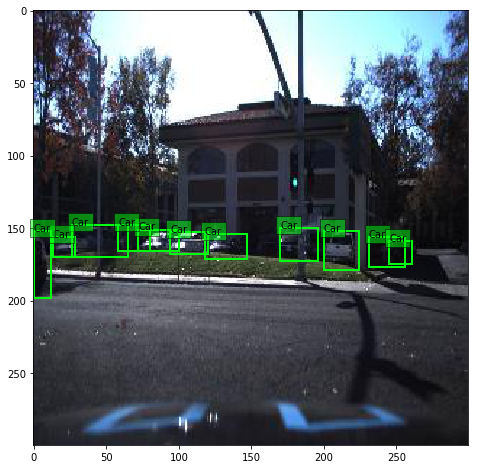

In [18]:
udacity_classes = ["Car", "Pedestrian", "Truck"]
for igt, img in enumerate(images):

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for irow in range(gts[igt].shape[0]):
        xmin = int(round(gts[igt][irow, 0] * img.shape[1]))
        ymin = int(round(gts[igt][irow, 1] * img.shape[0]))
        xmax = int(round(gts[igt][irow, 2] * img.shape[1]))
        ymax = int(round(gts[igt][irow, 3] * img.shape[0]))
        one_hot_enc = gts[igt][irow, 4:]
        label_name = udacity_classes[np.where(one_hot_enc)[0][0]] 
        display_txt = '{}'.format(label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

## Some more details on the prior boxes
Six layers are responsible for producing the final output that goes into the predictions, and are listed in the following table. The first column gives the layer names as used in the implementation. The second column shows the size of each layer. Note that the value 'None' indicates that the value depends on the input to the network, i.e the number of images fed in to the model. Some of the layer names in the implementation differ from the layer names used in the paper. The layer names from the paper are in the third column with an asterisk(\*).  The fourth column gives the number of prior boxes located at each grid cell:

Implementation Layer Name | Size | Paper Layer Name | Number of prior boxes at each grid cell
:---|:---|:---|:---
conv4_3 (Conv2D) | (None, 38, 38, 512) |  conv4_3\*  |   3 
fc7 (Conv2D)     | (None, 19, 19, 1024) | fc7\* | 6 
conv6_2 (Conv2D) | (None, 10, 10, 512) |  conv8_2\* | 6        
conv7_2 (Conv2D) | (None, 5, 5, 256) | conv9_2\* | 6 
conv8_2 (Conv2D) | (None, 3, 3, 256) | conv10_2\* | 6     
pool6 (GlobalAveragePooling2D) | (None, 256) | pool11\* |     6  

Since predictions are made for each prior box at each grid cell, the total number of predictions for each image is $3\cdot 38\cdot 38 + 6\cdot 19\cdot 19 + 6\cdot 10\cdot 10 + 6\cdot 5\cdot 5 + 6\cdot 3\cdot 3 + 6\cdot 1 = 4332+2166+600+150+54+6 = 7308$

Now let's visualize all the prior boxes. First we load a pickle file that stores the prior box definitions and pick out the locations and scale parameters.


In [19]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
mbox_priorbox = priors[:,0:4]
variances = priors[:,4:8]

bbox_util_training = BBoxUtility(NUM_CLASSES, priors)
#results = bbox_util.detection_out(preds)

To visualize the prior boxes, we first need to translate from the encodings to the image space. The function decode_boxes in the BBoxUtility class does this for us.

In [20]:
all_prior_boxes = bbox_util_training.decode_boxes(np.zeros_like(mbox_priorbox), mbox_priorbox, variances)

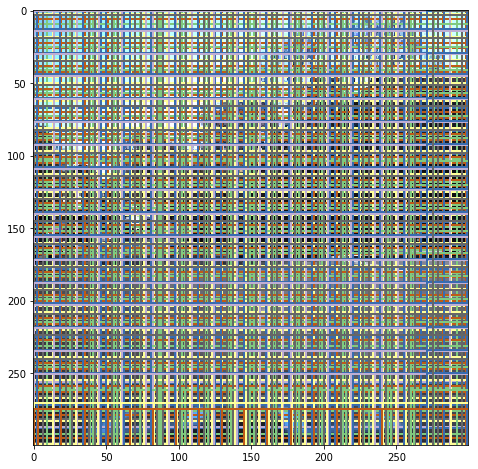

In [21]:
example_img = images[0]
boxes_per_layer = [0, 4332, 2166, 600, 150, 54, 6]
boxes_per_layer_cum = np.cumsum(boxes_per_layer)

colors = plt.cm.Accent(np.linspace(0, 1, 6)).tolist() 
# have a look at https://matplotlib.org/examples/color/colormaps_reference.html for other color maps

plt.imshow(example_img / 255.)
currentAxis = plt.gca()
ilayer = 1 # must be between 0 and 5
for irow in range(boxes_per_layer_cum[ilayer], boxes_per_layer_cum[ilayer+1]): 
    xmin = int(round(all_prior_boxes[irow, 0] * example_img.shape[1]))
    ymin = int(round(all_prior_boxes[irow, 1] * example_img.shape[0]))
    xmax = int(round(all_prior_boxes[irow, 2] * example_img.shape[1]))
    ymax = int(round(all_prior_boxes[irow, 3] * example_img.shape[0]))
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[irow % len(colors)] 
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

plt.show()

# Architecture of the model
So, what are the layers that an image is passed through to obtain the predictions? We'll investigate this in the following. First, let's print out the names of the layers in the model again

In [24]:
keras.utils.layer_utils.print_summary(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 300, 300, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

and compare these to the architecture shown in Figure 2 of the paper:

In [25]:
ssd_arch_img = plt.imread(os.path.expanduser('~/Documents/TrainingMaterial/objectRecognition/figs/ssd_architecture_larger.png'))

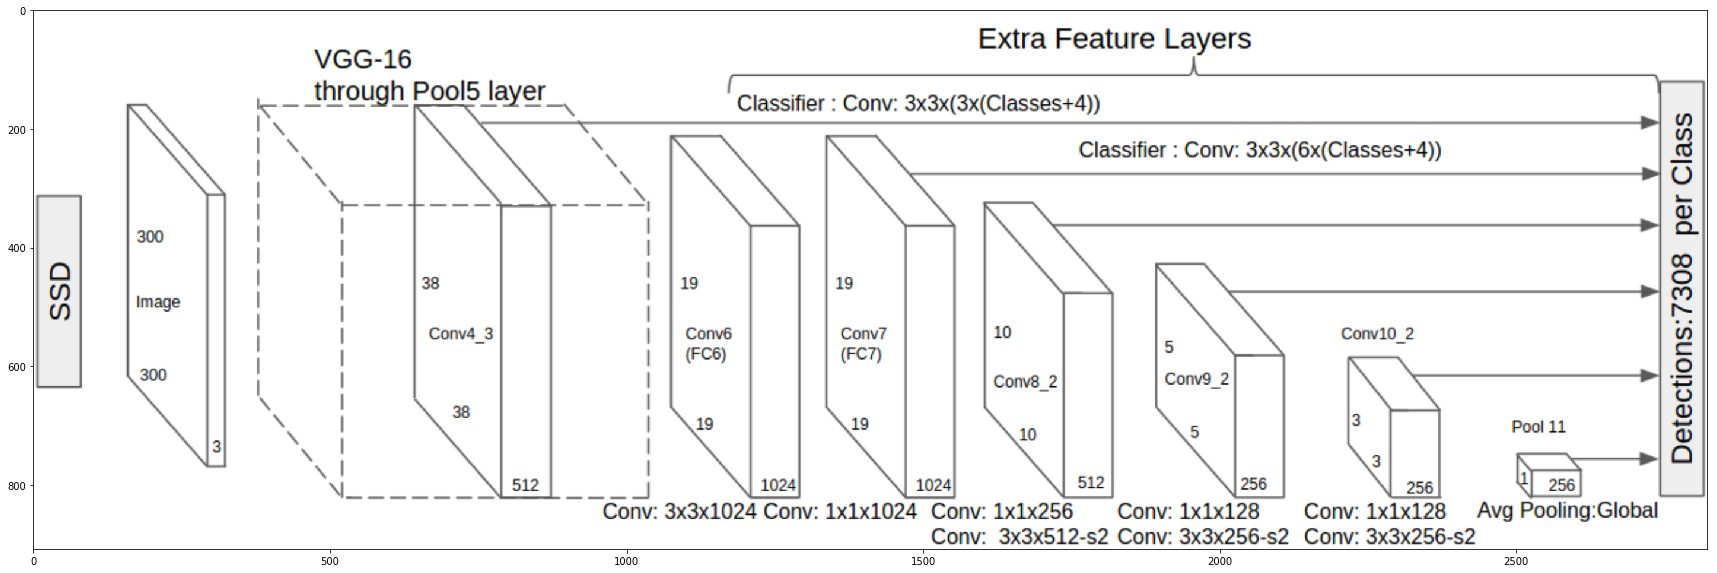

In [26]:
plt.figure(figsize=(30,30))
plt.imshow(ssd_arch_img)

Figure: top part of Figure 2 from version 2 of the SSD paper. This shows the architecture of SSD. From each layer that contributes to the classification, the following values are predicted: a confidence for each class as well as four corrections to the prior box regressing to an object's bounding box. From the first contributing layer (the 38 by 38 layer named conv4_3), three prior boxes are placed at each grid cell. Six prior boxes are placed at each grid cell for the five remaining contributing layers. As shown above, the the six prior boxes have different aspect ratios. Predictions from the different layers correspond to objects of different sizes. The larger the layer (38 by 38 being the largest), the smaller the object it can detect since each grid cell corresponds to a smaller part of the input image.

Now that we have seen the layers comprising the SSD model, let's visualize the output of some of the layers.

In [38]:
layer_name = 'conv4_3_norm_mbox_conf' #'conv4_3_norm_mbox_conf' #'conv6_1' #'conv1_1' # 'conv4_3_norm' 

intermediate_layer_model = Model(inputs=[model.input],
                                 outputs=[model.get_layer(layer_name).output])
intermediate_output = intermediate_layer_model.predict(inputs)

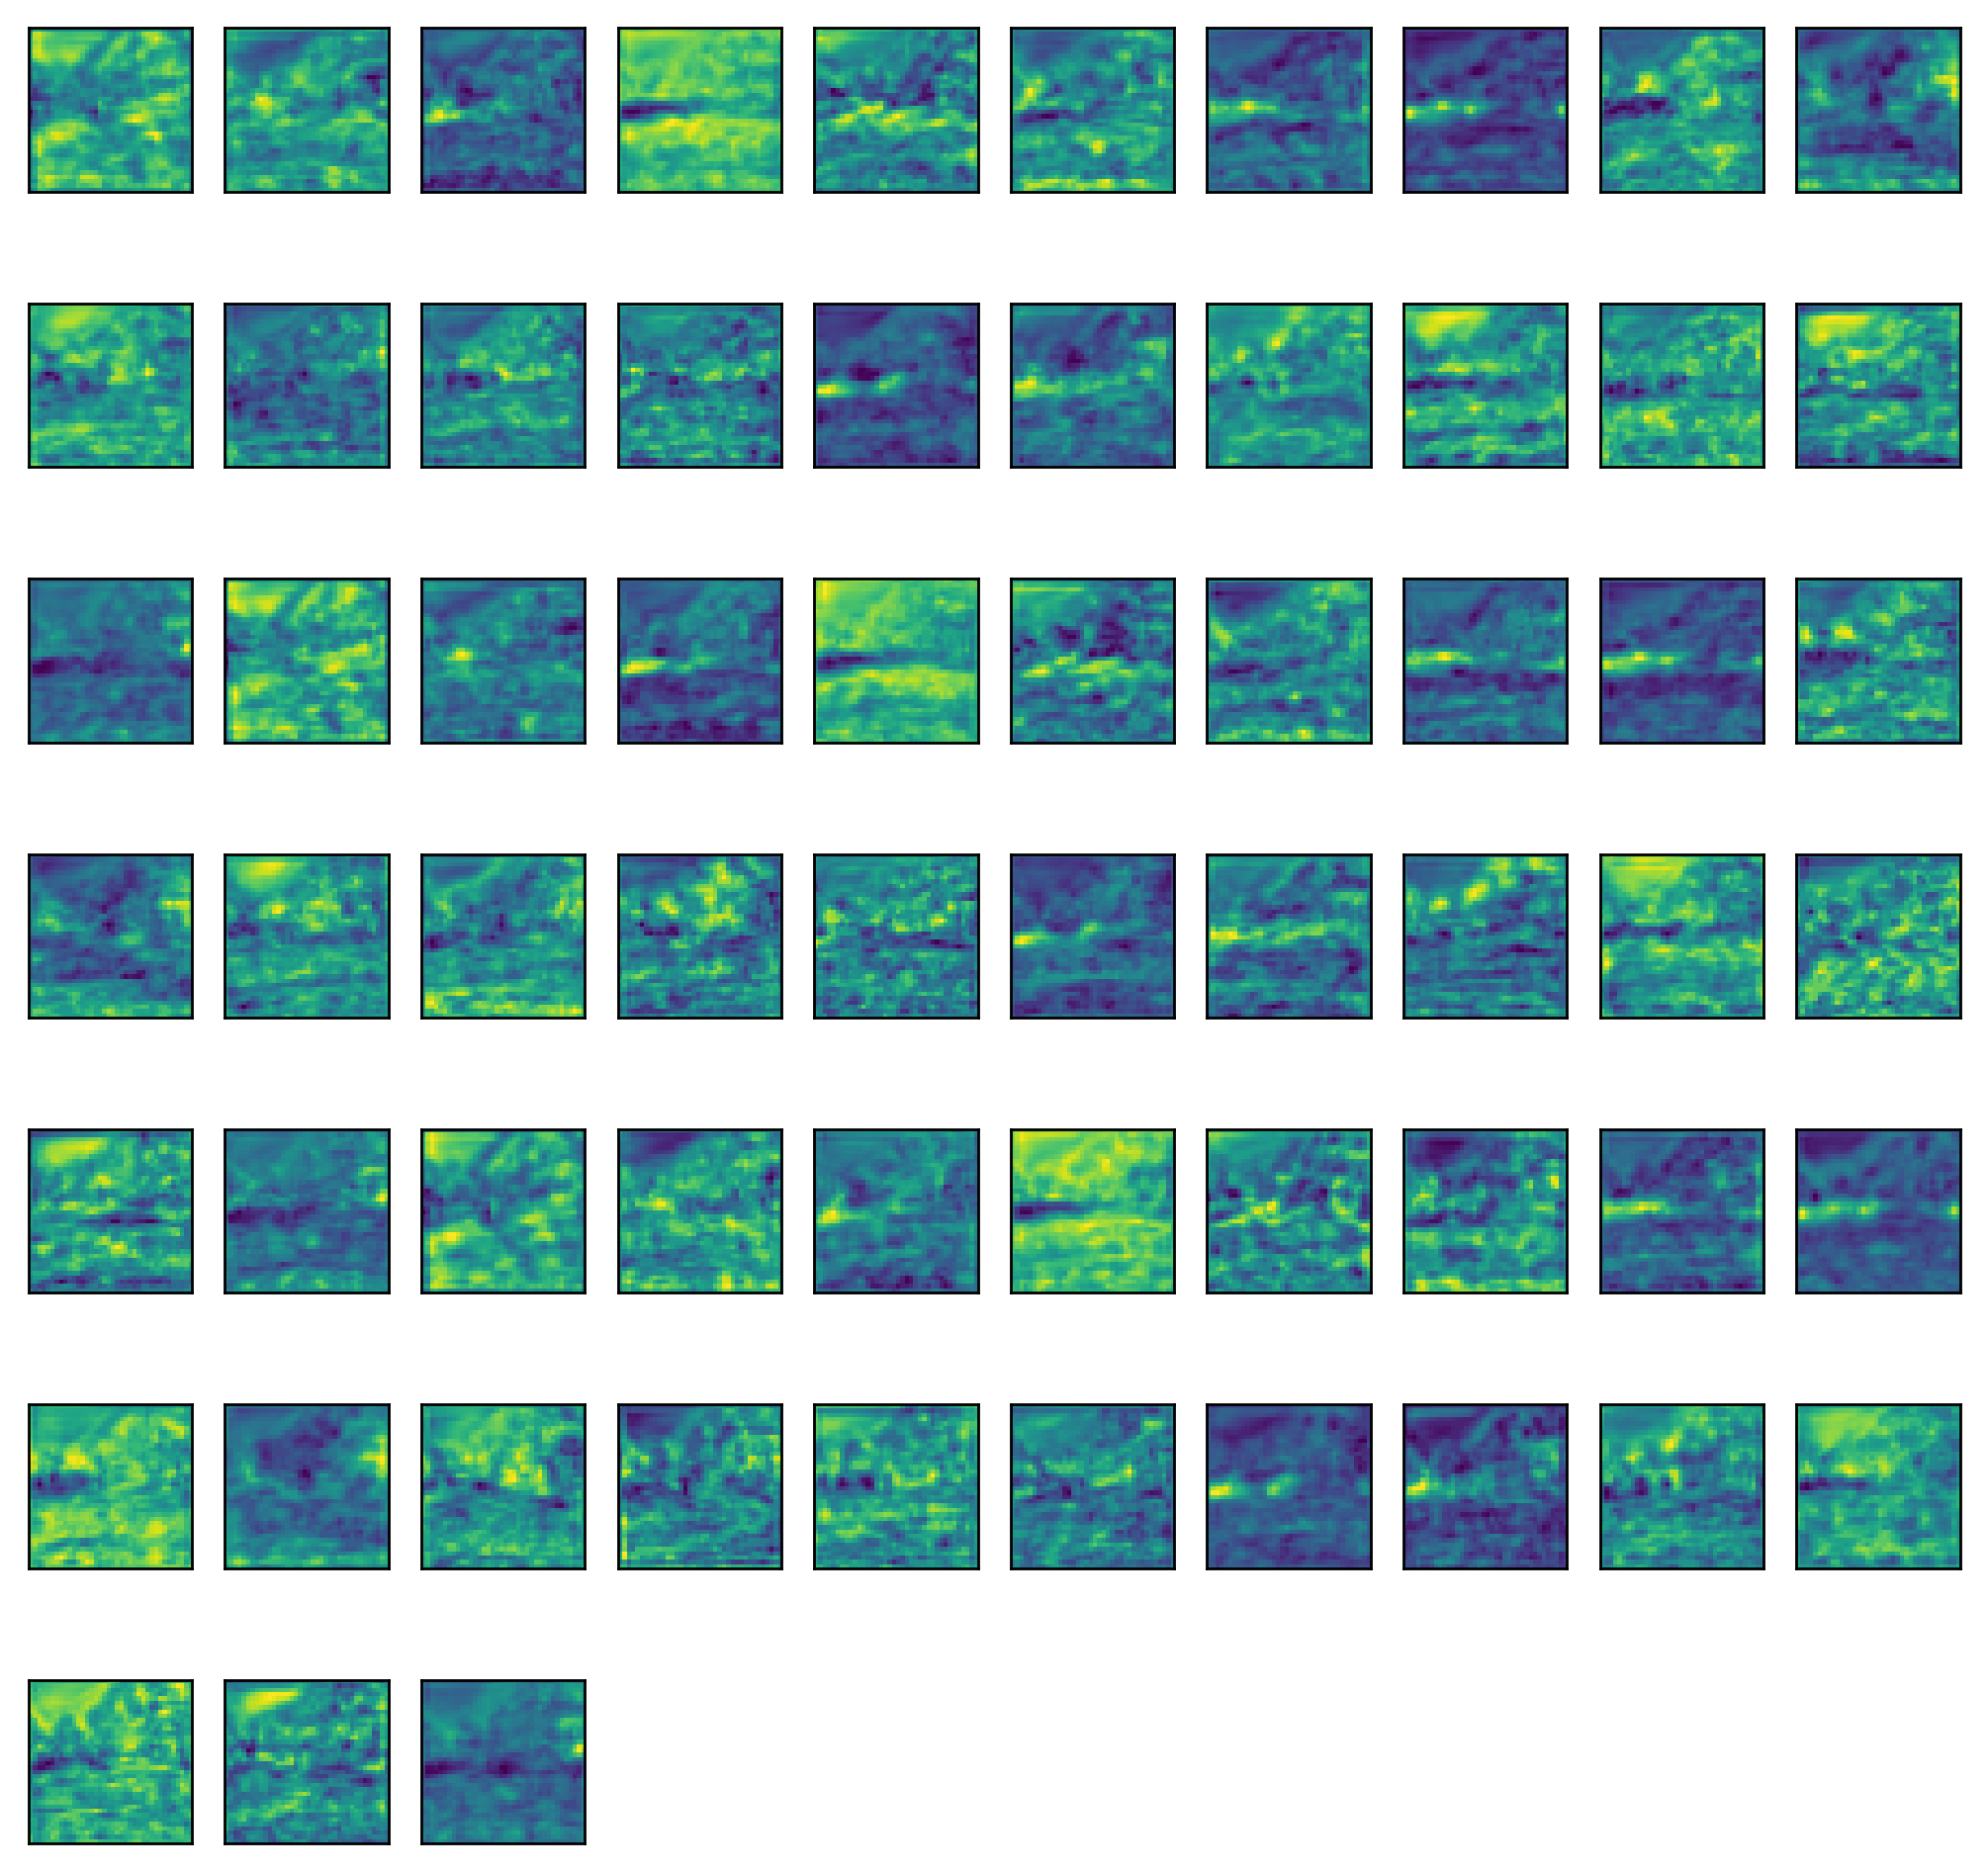

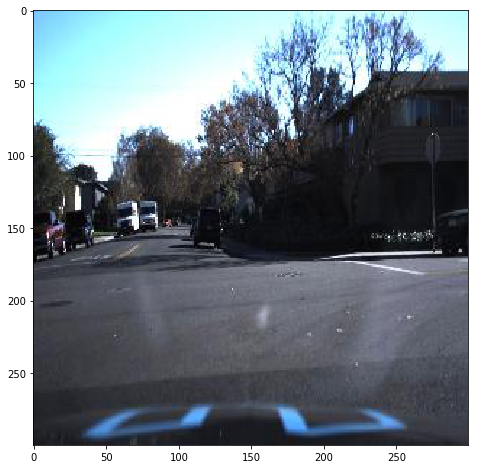

In [39]:
iimg = 0
#plt.imshow(intermediate_output[iimg, :,:, 300])
# setting nrows to 350 implies that --NotebookApp.iopub_data_rate_limit would have to be increased from the default
# setting
nrows = np.min([intermediate_output[iimg].shape[2] , 100])
n_fig_cols = 10 # number of columns to use when showing intermediate output feature maps
plt.figure(figsize=(n_fig_cols, np.ceil(nrows/np.square(n_fig_cols))*n_fig_cols), dpi = nrows*4)
for i in range(0, nrows):
    plt.subplot(nrows / n_fig_cols + 1, n_fig_cols, i + 1)
    #plt.imshow(images[i])
    plt.imshow(intermediate_output[iimg, :,:, i])
    plt.xticks([])
    plt.yticks([])

plt.figure()
plt.imshow(images[iimg])

# Loss function
The overall loss function is composed of different loss functions, that each seeks to optimize a particular aspect of the model. In this section, we'll have a look at these components and how they are combined for the final end-to-end trainable model. 

Let $N$ denote the number of prior boxes matched to any ground truth box. Matches are defined by first, for each ground truth bounding box, finding the prior box that has the highest Jaccard overlap (also known as Intersection over Union (IoU)) with the ground truth bounding box currently being matched. Once each ground truth bounding box has one matching prior box, any prior box with a Jaccard overlap above 0.5 with any ground truth bounding box is matched to that ground truth bounding box. This implies that each ground truth bounding box has at least one and possibly more than one prior box matched to it.

The background is treated as a class, and by convention assigned class number zero. Thus a prior box that does not match a ground truth box should have class zero predicted.

Also, let $x_{i,j}^p$ be an indicator for whether the $iˆ{th}$ prior box was matched to the $jˆ{th}$ ground truth box in class $p$. The indicators $x_{i,j}^p$ could be thought of as being stored in a third-order binary tensor. Since $N$ was defined as the number of prior boxes matching any ground truth box, we have $\sum\limits_{i, j, p} x_{i, j}^p = N$.

Furthermore, we let $c_i^p$ denote the confidence predicted by the $iˆ{th}$ prior box for class $p$.

The overall loss function is defined in equation (1) in version two of the SSD paper. It is defined as:

$L(x, c, l, g) = \frac{1}{N}\left(L_{conf}(x, c) + \alpha L_{loc}(x, l, g) \right) $.

The weight parameter $\alpha$ was set to one through cross-validation by the authors of the SSD paper and determines the relative importance of the confidence and location losses. The confidence loss $L_{conf}(x, c)$ is implemented as the softmax loss:

$L_{conf}(x, c) = -\sum\limits_{i, j, p} x_{i,j}^p \cdot \log\left( \frac{\exp(c_i^p)}{\sum_p \exp(c_i^p)}\right) $.

The location loss is defined as the smooth $L_1$ loss and calculated only for prior boxes matched to ground truth boxes, that is, for prior boxes matched to ground truth boxes not of the background class encoded with zero:

$L_{loc} = \sum\limits_{(i, j, p):\,  x_{i, j}^p==1 \, \land \, p>0} \, \sum\limits_{m \in \{cx, cy, w, h\}}   smooth_{L_1}(l_i^m - \hat{g}_j^m)$.

The indices $cx$, $cy$, $w$, and $h$ refer to the x- and y-coordinates of the center, the width, and the height of a bounding box, respectively. The smooth $L_1$ loss is defined as:

\begin{equation} 
L_1(z) = 
\begin{cases} 
      0.5z^2 & if \, |z| < 1 \\
      |z| - 0.5 & otherwise
\end{cases}
\end{equation}

and $l_i$ is the $i^{th}$ predicted bounding box parameters while $g_j$ is the ground truth bounding box parameters. Hence $l_i$ and $g_j$ are vectors of length four. Likewise, $d_i$ is the length-four vector containing the parameters of the prior box that was matched. Regression is done on corrections to the prior box, and we have the definitions:

$\hat{g}_j^{cx} = (g_j^{cx} - d_i^{cx})/d_i^w$,

$\hat{g}_j^{cy}=(g_j^{cy} - d_i^{cy})/d_i^h$,

$\hat{g}_j^w = \log(g_j^w/d_i^w)$

$\hat{g}_j^h = \log(g_j^h/d_i^h)$.

Notice that we regress to the difference in logarithms of the width and heights of bounding boxes. This ensures that large boxes are punished less for the same absolute error in width and height predictions than a smaller box would be.



# Training

As mentioned at the beginning, we are using Data Set 1 from https://github.com/udacity/self-driving-car/tree/master/annotations. In the previous sections, we saw how a model pre-trained on VOC data worked on images from this data set. We will start by seeing how the data can be prepared to fit the format expected by the model, as well as split into train_val and test sets. To enable usage of the pre-defined model architecture and starting from the pre-trained weights, images are re-sized to 300 by 300 pixels.

## Preparing the data

In [26]:
import pickle
import os
import importlib
import get_data_from_crowdai
importlib.reload(get_data_from_crowdai)
from get_data_from_crowdai import crowdAI_preprocessor
from scipy.misc import imread, imsave
import glob
import numpy as np
from skimage.transform import resize

from ssd_training import MultiboxLoss
from random import shuffle
from scipy.misc import imresize



In [27]:
udacity_data_path = os.path.expanduser('~/Documents/publicData/udacity_selfdrivingcar/object-detection-crowdai') 
labels_path = os.path.join(udacity_data_path, 'labels.csv')
imgspath = udacity_data_path
imgspath_resized300_300 = os.path.expanduser('~/Documents/publicData/udacity_selfdrivingcar/object-detection-crowdai_resized300_300')

In [28]:
imgfiles = glob.glob(os.path.join(imgspath,  "*.jpg"))


In [29]:
img = imread(imgfiles[0])
img_height = img.shape[0] # 1200
img_width = img.shape[1] # 1920

In [30]:
data_preprocessed = crowdAI_preprocessor(labels_path, img_height, img_width)

In [31]:
data = data_preprocessed.data

In [32]:
pickle.dump(data,open('crowdai_udacity.p','wb'))

In [33]:
# resize images and store in other folder
if False: # only run this code if you need to resize images 
    for i in range(0, len(imgfiles)):
        img = imread(imgfiles[i])
        base_name = imgfiles[i].split('/')[-1]
        newimg = resize(img, [300, 300], mode = 'symmetric')
        imsave(name = os.path.join(imgspath_resized300_300, base_name), arr=newimg)


Now we have resized the images appropriately and have interpreted the labels in the csv file. Now let's split the data into train_val and test sets.

In [34]:
train_val_file = 'crowdai_udacity_trainval.p'
test_file = 'crowdai_udacity_test.p'
train_val_exists = os.path.isfile(train_val_file)
test_file_exists = os.path.isfile(test_file)
test_prop = 0.2
alldata = pickle.load(open('crowdai_udacity.p', 'rb'))

if train_val_exists + test_file_exists == 1:
    print("only one of the train_val and test files exists." +
          "To make sure the two files are mutually exclusive, re-generate both")
elif train_val_exists + test_file_exists == 0:
    allkeys = list(alldata) #alldata.keys()
    nobs = len(allkeys)
    test_inds = np.random.choice(a=nobs, size=int(np.floor(test_prop*nobs)), replace=False)
    train_val_inds = np.setdiff1d(range(0, nobs), test_inds)
    test_keys = np.asarray(allkeys)[test_inds]
    train_val_keys = np.asarray(allkeys)[train_val_inds]
    test_dict = {k: alldata.get(k) for k in test_keys}
    train_val_dict = {k: alldata.get(k, None) for k in train_val_keys}
    pickle.dump(test_dict,open('crowdai_udacity_test.p','wb'))
    pickle.dump(train_val_dict,open('crowdai_udacity_trainval.p','wb'))


else:
    print("files already exist")

files already exist


Let's have a look at the ground truth annotations for a couple of files.

In [35]:
{k: alldata[k] for k in ('1479500787628796061.jpg', '1479505233428360081.jpg')}

{'1479500787628796061.jpg': array([[ 0.3234375 ,  0.43583333,  0.41822917,  0.53333333,  1.        ,
          0.        ,  0.        ],
        [ 0.79375   ,  0.435     ,  0.8171875 ,  0.47833333,  0.        ,
          0.        ,  1.        ],
        [ 0.94270833,  0.44416667,  0.98854167,  0.49166667,  1.        ,
          0.        ,  0.        ],
        [ 0.83125   ,  0.45166667,  0.846875  ,  0.47666667,  1.        ,
          0.        ,  0.        ],
        [ 0.81614583,  0.4525    ,  0.83177083,  0.4775    ,  1.        ,
          0.        ,  0.        ]]),
 '1479505233428360081.jpg': array([[ 0.67916667,  0.43666667,  0.80989583,  0.59      ,  1.        ,
          0.        ,  0.        ],
        [ 0.80052083,  0.44166667,  0.890625  ,  0.52166667,  1.        ,
          0.        ,  0.        ],
        [ 0.38958333,  0.45416667,  0.4234375 ,  0.50083333,  1.        ,
          0.        ,  0.        ],
        [ 0.54166667,  0.44583333,  0.57395833,  0.49333333,  1.

Let's check that the splitting went as expected:

## Run the training

In [36]:
NUM_CLASSES = 4
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [37]:
gt = pickle.load(open('crowdai_udacity_trainval.p', 'rb'))  #pickle.load(open('crowdai_udacity.p', 'rb')) #pickle.load(open('VOC2007.p', 'rb')) #pickle.load(open('crowdai_udacity.p', 'rb'))#pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [38]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [39]:
gen = Generator(gt, bbox_util, 16, imgspath_resized300_300+"/",
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [40]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)

In [41]:
freeze =  ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3',#,
          'conv4_1', 'conv4_2']#, 'conv4_3']#, 
#           'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [42]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [43]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [44]:
nb_epoch = 1
history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=gen.train_batches,
                              epochs=nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches,
                              workers=1)

/Users/lf186013/anaconda/envs/objRecTut/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
  15/5900 [..............................] - ETA: 158067s - loss: 4.7979

KeyboardInterrupt: 

In [ ]:
NUM_CLASSES